- Use fundamental analysis to screen stocks based on financial metrics such as P/E ratio, earnings growth, dividend yield, and debt levels.
- A random forest classifier is trained on financial indicators to predict whether a stock should be included in the portfolio

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

[*********************100%%**********************]  10 of 10 completed


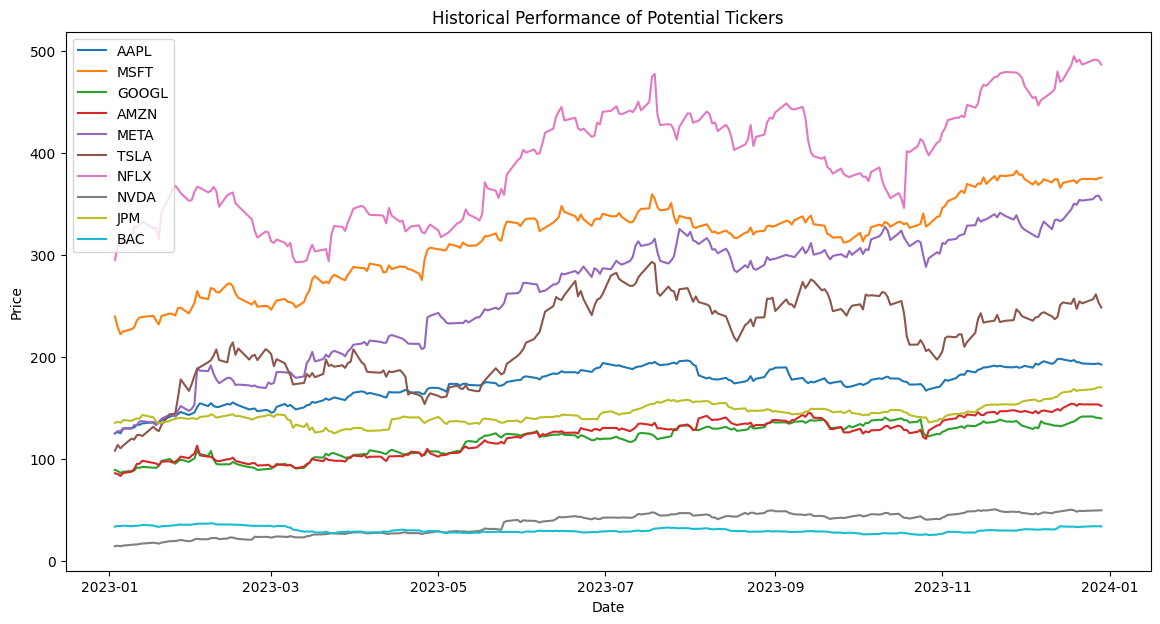

In [55]:
# Define a list of potential tickers
potential_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'JPM', 'BAC']

# Load historical data
data = yf.download(potential_tickers, start='2023-01-01', end='2024-01-01')['Close']

# Calculate returns
returns = data.pct_change().dropna()

# Calculate mean returns and standard deviation
mean_returns = returns.mean()
std_devs = returns.std()

# Calculate correlation matrix
correlation_matrix = returns.corr()

# Plotted the historical performance to visualize the price trends.
plt.figure(figsize=(14, 7))
for ticker in potential_tickers:
    plt.plot(data[ticker], label=ticker)
plt.title('Historical Performance of Potential Tickers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

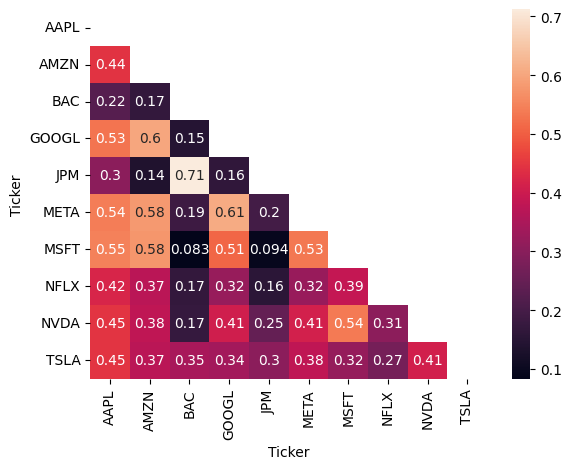

In [56]:
corr = correlation_matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask = mask)
plt.show()

Considered Features:
- PE Ratio (Price-to-Earnings Ratio): Indicates how much investors are willing to pay per dollar of earnings.
- Debt-to-Equity Ratio: Measures a company's financial leverage.
- Revenue Growth: Indicates the growth rate of a company's sales.
- Historical Return: The historical performance of the stock.
- Sector: The sector to which the company belongs (encoded as dummy variables).

The random forest evaluates the importance of each feature in making predictions. Features that contribute more to reducing impurity (uncertainty) in the data are considered more important.

In [57]:
financials = {ticker: yf.Ticker(ticker).financials for ticker in potential_tickers}
financials['NVDA'] #01-31
financials['TSLA'] #12-31
financials['AAPL'] #09-30

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.147,0.162,0.133,0.144
Normalized EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
Net Income From Continuing Operation Net Minority Interest,96995000000.0,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11519000000.0,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,214137000000.0,223546000000.0,212981000000.0,169559000000.0
EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
EBIT,117669000000.0,122034000000.0,111852000000.0,69964000000.0
Net Interest Income,-183000000.0,-106000000.0,198000000.0,890000000.0
Interest Expense,3933000000.0,2931000000.0,2645000000.0,2873000000.0


In [58]:
# Example financial indicators
financial_indicators = pd.DataFrame()

Calculate PE ratio (Price-to-Earnings Ratio)
- A high P/E ratio can mean that a stock’s price is high relative to earnings and possibly overvalued.
- A low P/E ratio might indicate that the current stock price is low relative to earnings.
- Note that a good P/E for one group or sector could be a poor P/E for another sector, so comparisons should compare similar companies.

In [59]:
pe_ratio = {}
for ticker in potential_tickers:
    # Get the latest close price
    price = data[ticker].iloc[-1]
    # # Get the annual earnings per share (EPS)
    # earnings = financials[ticker].loc['Net Income'] / financials[ticker].loc['Shares Outstanding']
    pe_ratio[ticker] = price / financials[ticker].loc['Basic EPS'].mean() # Using mean EPS for simplicity
# Example financial indicators
financial_indicators['PE Ratio'] = pd.Series(pe_ratio)
# financial_indicators['PE Ratio'].values 

Calculate Debt-to-Equity Ratio
- Stockholders' equity is the remaining assets available to shareholders after all liabilities are paid.

In [60]:
debt_equity_ratio = {}

for ticker in potential_tickers:
    try:
        # Get balance sheet data
        balance_sheet = yf.Ticker(ticker).balance_sheet
        
        # Get the latest total debt and total equity
        total_debt = balance_sheet.loc['Total Debt'].iloc[0]
        total_equity = balance_sheet.loc['Stockholders Equity'].iloc[0]
        
        # Calculate debt-to-equity ratio
        debt_equity_ratio[ticker] = total_debt / total_equity
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        debt_equity_ratio[ticker] = None

financial_indicators['Debt-to-Equity Ratio'] = pd.Series(debt_equity_ratio)
financial_indicators['Debt-to-Equity Ratio'].values

array([1.99417501, 0.25002887, 0.10058614, 0.67175728, 0.24309255,
       0.15284031, 0.7063843 , 0.25724789, 1.3314007 , 1.14625951])

In [61]:
# balance_sheet = yf.Ticker('AAPL').balance_sheet
# balance_sheet.index

Calculate revenue growth 
- It involves comparing the current revenue with the revenue from a previous period (often the previous year) and expressing the change as a percentage. 

In [62]:
# Calculate Revenue Growth (hypothetical growth rates based on stock prices)
revenue_growth = {}

for ticker in potential_tickers:
    try:
        # Get historical stock prices
        hist = yf.Ticker(ticker).history(period="1y")
        
        # Calculate revenue growth as percentage change in closing prices
        current_price = hist['Close'].iloc[-1]
        previous_price = hist['Close'].iloc[0]
        growth_rate = (current_price - previous_price) / previous_price
        
        revenue_growth[ticker] = growth_rate
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        revenue_growth[ticker] = None

financial_indicators['Revenue Growth'] = pd.Series(revenue_growth)
financial_indicators['Revenue Growth'].values

array([ 0.13988817,  0.28358131,  0.33164018,  0.43569143,  0.58684998,
       -0.14659006,  0.45415396,  1.46770177,  0.37188337,  0.30412837])

Calculate historical_return

In [63]:
# Calculate historical return
historical_return = {}
  # Calculate daily returns
        
for ticker in potential_tickers:
    try:
      # Calculate cumulative returns
      data['Cumulative Return'] = (1 +  data[ticker].pct_change()).cumprod() - 1
      historical_return[ticker] =  data['Cumulative Return'].fillna(0).values.mean()

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

financial_indicators['historical return'] = pd.Series(historical_return)
financial_indicators['historical return'].values

array([ 0.37961942,  0.3104224 ,  0.33297483,  0.41427174,  1.09575344,
        1.01179688,  0.32309837,  1.55461132,  0.06611904, -0.10307725])

Use Random Forest to select tickers 

In [64]:
# Example financial indicators (dummy data for illustration)
data = pd.DataFrame({
    'ticker': potential_tickers,
    'pe_ratio': financial_indicators['PE Ratio'].values,
    'debt_equity_ratio': financial_indicators['Debt-to-Equity Ratio'].values,
    'revenue_growth': financial_indicators['Revenue Growth'].values,
    'historical_return': financial_indicators['historical return'].values,
    'sector': ['Tech', 'Tech', 'Tech', 'Tech', 'Tech', 'Auto', 'Entertainment', 'Tech', 'Finance', 'Finance']
})

# Encode categorical variables
data = pd.get_dummies(data, columns=['sector'])

# Define target variable based on historical returns, it can be modified to be based on a meaningful financial criterion (e.g., past performance, expert ratings, or some other financial metric)
# For this example, we use a binary classification: 1 if historical return > 0, else 0
data['target'] = (data['historical_return'] > 0).astype(int)

# Define features (X) and labels (y)
X = data.drop(['ticker', 'target'], axis=1)
y = data['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Select top tickers based on model prediction
# Note: Since we used the 'historical_return' > 0 criterion, we may not need this step.
# If you still want to select tickers based on the model predictions:
selected_tickers = data['ticker'][data['target'] == 1].tolist()
print("Selected Tickers based on historical returns:", selected_tickers)

# Optionally, print feature importances to understand the contribution of each feature
importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")

Model Accuracy: 0.50
Selected Tickers based on historical returns: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'JPM']
Feature Importances:
pe_ratio: 0.2367
debt_equity_ratio: 0.1416
revenue_growth: 0.1122
historical_return: 0.2608
sector_Auto: 0.0029
sector_Entertainment: 0.0113
sector_Finance: 0.1848
sector_Tech: 0.0498
